In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from itertools import cycle, islice, combinations
from scipy.stats import ttest_rel, ttest_ind
from statsmodels.stats.multitest import multipletests

In [28]:
def get_membrane_blebbing_data(experiment_folder, istest=False):
    """generate box plot to compare conditions or summarize experiment"""
    subdirs = os.listdir(experiment_folder);
    experiment_title = os.path.basename(experiment_folder)
    if not all(["output" in dirname for dirname in subdirs]):
        condition_labels = subdirs;
    else:
        condition_labels = [experiment_title];
    dfs = []
    for condition in condition_labels:
        if (len(condition_labels) == 1) and condition_labels[0] == experiment_title:
            data_folder = experiment_folder;
        else:
            data_folder = os.path.join(experiment_folder, condition);
        for subfolder in os.listdir(data_folder):
            df = pd.read_csv(os.path.join(data_folder, subfolder, "Intensity ratios.csv"));
            df['output_folder'] = subfolder;
            df['Condition'] = condition;
            if istest:
                df['outer/inner'] = np.random.normal(loc=df['outer/inner'], scale=df['outer/inner'].std())
            dfs.append(df);
    conditionwise_data = pd.concat(dfs, ignore_index=True);
    return conditionwise_data
        
def color_cycle(base_list_of_colors=['r', 'g', 'b', 'y', 'm', 'c'], l=6):
    """Return a list of colors of length l, looping where necessary"""
    return list(islice(cycle(base_list_of_colors), None, l));

def plot_time_dependence_by_condition(df, istest=False):
    """generate line plot showing evolution of intensity ration with time, per condition"""
    conditions = df['Condition'].unique();
    clrs = color_cycle(l=len(conditions));
    if istest:
        for idx, condition in enumerate(conditions):
            df.loc[(df['Condition'] == condition), 'outer/inner'] = df.loc[(df['Condition'] == condition), 'outer/inner']+idx/5;
    ax = df.groupby(['Condition', 'Frame']).median()['outer/inner'].unstack(level=0).plot(color=clrs);
    ax.set_ylabel("Actin intensity ratio");
    for idx, condition in enumerate(conditions):
        ax.fill_between(df.groupby('Frame')['Frame'].mean(), 
                    df.groupby(['Condition', 'Frame']).quantile(0.25)['outer/inner'].unstack(level=0)[condition], 
                    df.groupby(['Condition', 'Frame']).quantile(0.75)['outer/inner'].unstack(level=0)[condition], 
                    color=clrs[idx], alpha=0.2)
    ax.set_title("Time evolution of actin intensity ratios");
    box = ax.get_position();
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    
def p_to_stars(p):
    """map p-values to stars to display on graphs"""
    if p > 0.05:
        return 'n.s.';
    elif p > 0.01:
        return '*';
    elif p > 0.005:
        return '**';
    else:
        return '***';

def plot_condition_comparison(df, istest=False):
    """generate box plot to compare two or more conditions"""
    conditions = list(df['Condition'].unique());
    if istest:
        for idx, condition in enumerate(conditions):
            df.loc[(df['Condition'] == condition), 'outer/inner'] = df.loc[(df['Condition'] == condition), 'outer/inner']+idx/150;
    summary = df.groupby('output_folder').mean();
    sub = df.drop_duplicates('output_folder');
    summary['Condition'] = sub.set_index('output_folder')['Condition'];
    ax = summary.boxplot(column='outer/inner', by='Condition', grid=False, figsize=(8,8));
    ax.set_ylabel("Actin intensity ratio");
    ax.set_xlabel('');
    plt.suptitle('')
    ax.set_title("Actin intensity ratios per condition");
    
    # deal with displaying significance
    combs = sorted(list(combinations(conditions, r=2)), key=lambda x: abs(conditions.index(x[1]) - conditions.index(x[0])));
    start_ylims = ax.get_ylim();
    start_plot_height = ax.get_ylim()[1] - ax.get_ylim()[0];
    height_per_comparison = 0.1 * (start_ylims[1] - start_ylims[0]);
    ax.set_ylim(start_ylims[0], start_ylims[1] + len(combs) * height_per_comparison);
    
    ps = [];
    for comb in combs:
        p = ttest_ind(df.loc[(df['Condition'] == comb[0]), 'outer/inner'], 
                        df.loc[(df['Condition'] == comb[1]), 'outer/inner']).pvalue;
        ps.append(p);
        
    # do multiple comparisons correction
    print('Uncorrected ps = ' + str(ps));
    ps = multipletests(ps)[1].tolist();
    print('Corrected ps = '  + str(ps));
    
    for idx, comb in enumerate(combs):
        lx = ax.get_xticks()[conditions.index(comb[0])];
        rx = ax.get_xticks()[conditions.index(comb[1])];
        mid = lx/2 + rx/2;
        lry = start_ylims[1] + (idx + 0.5) * height_per_comparison;
        h = height_per_comparison/4;
        
        barx = [lx, lx, rx, rx];
        bary = [(lry-h), lry, lry, (lry-h)];
        ax.plot(barx, bary, c='black');
        ax.text(mid, lry + h/2, p_to_stars(ps[idx]));   
        
    print(combs);
    print("p = " + str([round(p,3) for p in ps]));
    print([p_to_stars(p) for p in ps]);
    

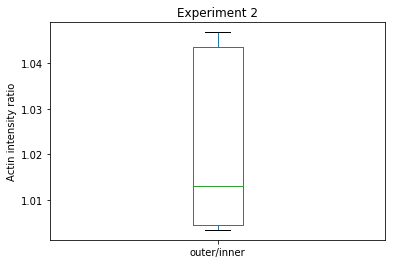

In [29]:
# test
experiment_folder = "D:\\data\\Joyce data test\\Experiment 2"
df = get_membrane_blebbing_data(experiment_folder, istest=True);
ax = df.groupby('output_folder').mean().boxplot(column='outer/inner', grid=False)
ax.set_ylabel("Actin intensity ratio");
ax.set_title(os.path.basename(experiment_folder));


Uncorrected ps = [0.010374464857211668, 0.028264293321396593, 8.605007264928139e-07]
Corrected ps = [0.020641300193349865, 0.028264293321396572, 2.5814999580209275e-06]
[('48 hpf', '50 hpf'), ('50 hpf', '60 hpf'), ('48 hpf', '60 hpf')]
p = [0.021, 0.028, 0.0]
['*', '*', '***']


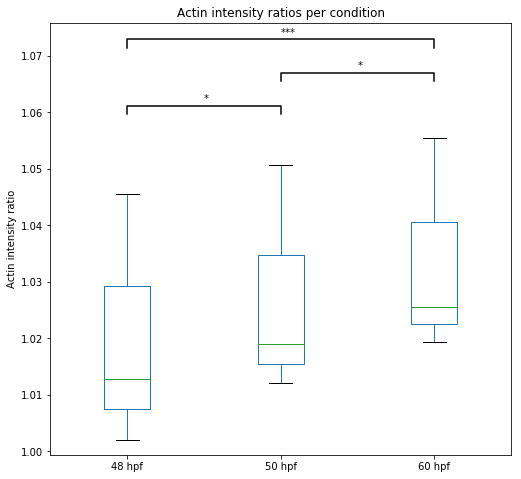

In [30]:
# test2
experiment_folder = "D:\\data\\Joyce data test\\Experiment 2"
df = get_membrane_blebbing_data(experiment_folder, istest=True);
#print(df)
plot_condition_comparison(df, istest=True);


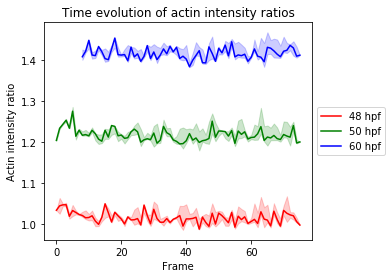

In [137]:
# test3   
experiment_folder = "D:\\data\\Joyce data test\\Dummy experiment 2"
experiment_folder = "D:\\data\\Joyce data test\\Experiment 2"
df = get_membrane_blebbing_data(experiment_folder, istest=True);
plot_time_dependence_by_condition(df, istest=True)

#df.groupby(['Condition', 'Frame']).quantile(0.25)['outer/inner'].unstack(level=0).plot(ax=ax, alpha=0.4, color=['r', 'g', 'b'], legend=False);
#df.groupby(['Condition', 'Frame']).quantile(0.75)['outer/inner'].unstack(level=0).plot(ax=ax, alpha=0.4, color=['r', 'g', 'b'], legend=False);

#print(df[df['Condition'] == '60 hpf'])


In [170]:
ps = [0.001, 0.2, 0.21243]
print(['{:03.3f}'.format(p) for p in ps])

['0.001', '0.200', '0.212']


In [48]:
conditions = ['a', 'b', 'c', 'd', 'e']
comb_idx = sorted(list(combinations([i for i in range(len(conditions))], r=2)), key=lambda x: abs(x[1] - x[0]));
combs = sorted(list(combinations(conditions, r=2)), key=lambda x: abs(conditions.index(x[1]) - conditions.index(x[0])));
print(comb_idx);
print(combs)

[(0, 1), (1, 2), (2, 3), (3, 4), (0, 2), (1, 3), (2, 4), (0, 3), (1, 4), (0, 4)]
[('a', 'b'), ('b', 'c'), ('c', 'd'), ('d', 'e'), ('a', 'c'), ('b', 'd'), ('c', 'e'), ('a', 'd'), ('b', 'e'), ('a', 'e')]
